# Metropolis-Hasting MCMC sampling of a Poisson distribution 

This notebook was adapted from Example 1, section 12.2 in Gregory's *Bayesian Logical Data Analysis for the Physical Sciences*.

The Poisson discrete random variable from scipy.stats is defined by (see [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html))

$$
p(k|\mu) = \frac{\mu^k e^{-\mu}}{k!} \quad \mbox{for }k\geq 0 \;.
$$

where $k$ is an integer and $\mu$ is called the shape parameter. The mean and variance of this distribution are both equal to $\mu$. (Note: Gregory uses a different notation, but we'll stay consistent with scipy.stats.)

By "sampling a Poisson distribution" we mean we will obtain a set of $k$ values: $\{k_1, k_2, k_3, \ldots\}$ that follow this distribution.  That is, for a particular $k_i$, the probability to get that value should be what we get by evaluating $p(k_i|\mu)$. We know we've succeeded if we make a histogram of our set of $k_i$s and it looks like $p(k|\mu)$ (scaled to line up or else our histogram needs to be normalized to one).

The method we'll use is generically called Markov chain Monte Carlo or MCMC.  A Markov chain starts with some initial value, and then each successive value is generated from the previous one.  But it is not deterministic: when the new value is chosen, there is a random number involved.  The particular version of MCMC used here is called Metropolis-Hasting. You may be familiar with this from a statistical mechanics class, where it is typically applied to the Ising model.

We'll do the Metropolis-Hasting sampling as follows:
1. Choose an initial $k$ (call it $k_0$), having already fixed $\mu$.
2. Given $k_i$, sample a uniform random number $x$ from 0 to 1 (so $x \sim U(0,1)$) and propose $k' = k_i + 1$ if the $x > 0.5$, otherwise propose $k' = k_i - 1$.
3. Compute the Metropolis ratio $r = p(k'|\mu)\, /\, p(k_i|\mu)$ using the discrete Poisson distribution.
4. Given another uniform random number $y \sim U(0,1)$, $k_{i+1} = k'$ if $y \leq r$, else $k_{i+1} = k_i$ (i.e., keep the same value for the next $k$).
5. Repeat 2.-4. until you think you have enough samples of $k$.
6. When graphing the posterior or calculating averages, skip the first values until the sampling has equilibrated (this is generally called the "burn-in" or "warm-up").

In practice we'll carry this out by generating all our uniform random numbers at the beginning using `scipy.stats.uniform.rvs`.

Here, $q(k'|k) = \frac{1}{2}$ for all neighboring pairs $(k,k')$, since the probability of stepping to $k' = k_i\pm 1$ is $\frac{1}{2}$ given each step $k_i$ (c.f. step 2).

Exception: if $k_i=0$, then $q(1|k_i) = q(0|k_i) = \frac{1}{2}$ because Poisson distribution vanishes at negative integers.

In [1]:
%matplotlib inline  

import numpy as np
from math import factorial

# We'll get our uniform distributions from stats, but there are other ways.
import scipy.stats as stats  

import matplotlib.pyplot as plt
import seaborn; seaborn.set() # for nicer plot formatting

In [2]:
def poisson(k, mu):
    """
    Returns a Poisson distribution value for k with mean mu
    """
    return mu**k * np.exp(-mu) / factorial(k) 

In the following we have the steps 1-6 defined above marked in the code. *Step through the implementation and ask questions about what you don't understand.*

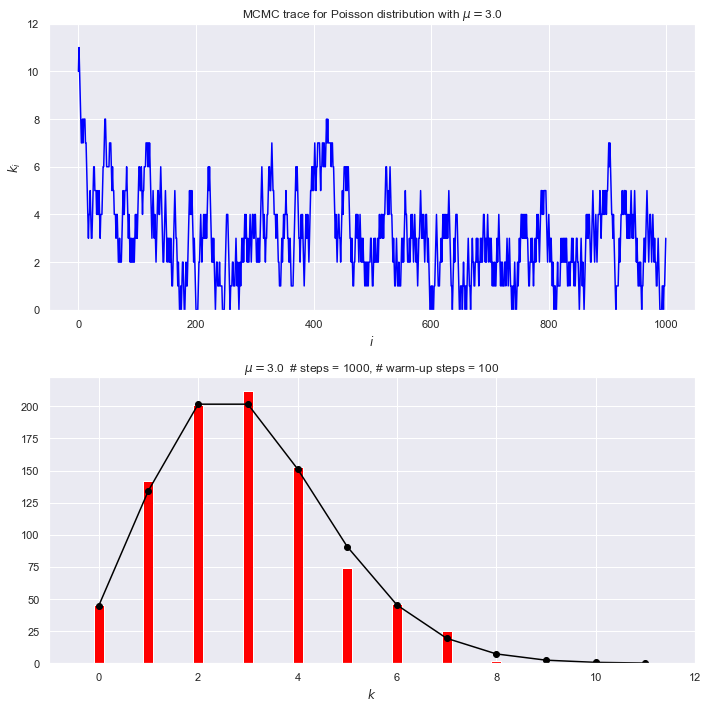

In [11]:
# 1. Set mu and k0
mu = 3.
k0 = 10    

num_steps = 1000  # number of MCMC steps we'll take
# generate the two sets of uniform random numbers we'll need for 2. and 4.
uniform_1 = stats.uniform.rvs(size=num_steps)  
uniform_2 = stats.uniform.rvs(size=num_steps)

k_array = np.zeros(num_steps, dtype=int)
k_array[0] = k0

# 5. Loop through steps 2-4
for i in range(num_steps-1):  # num_steps-1 so k_array[i+1] is always defined
    # 2. Propose a step
    k_now = k_array[i]
    if uniform_1[i] > 0.5:
        kp = k_now + 1          # step to the right
    else:
        kp = max(0, k_now - 1)  # step to the left, but don't go below zero
    
    # 3. Calculate Metropolis ratio
    metropolis_r = poisson(kp, mu) / poisson(k_now, mu)
    # 4. Accept or reject
    if uniform_2[i] <= metropolis_r:
        k_array[i+1] = kp
    else:
        k_array[i+1] = k_now

# 6. Choose how many steps to skip
warm_up_steps = 100

# Set up for side-by-side plots
fig = plt.figure(figsize=(10,10))

# Plot the trace (that means k_i for i=0 to num_steps)
ax_trace = fig.add_subplot(2, 1, 1)    
ax_trace.plot(range(num_steps), k_array, color='blue')
ax_trace.set_ylim(0, 12)
ax_trace.set_xlabel(r'$i$')
ax_trace.set_ylabel(r'$k_i$')
trace_title = rf'MCMC trace for Poisson distribution with $\mu = ${mu:.1f}'
ax_trace.set_title(trace_title)

# Plot the Poisson distribution
ax_plot = fig.add_subplot(2, 1, 2)
bin_num = 12
n_pts = range(bin_num)
    
# Scale exact result to the histogram, accounting for warm_up_steps    
poisson_pts = [(num_steps - warm_up_steps) * poisson(n, mu) for n in n_pts]     
    
# Plot the exact distribution    
ax_plot.plot(n_pts, poisson_pts, marker='o', color='black') 
# Histogram k_i beyond the warm-up period
ax_plot.hist(k_array[warm_up_steps:], bins=n_pts,
             align='left', rwidth=0.2, color='red')
ax_plot.set_xlim(-1, bin_num)
ax_plot.set_xlabel(r'$k$')
plot_title = rf'$\mu = ${mu:.1f}  # steps = {num_steps:d},' \
               + f' # warm-up steps = {warm_up_steps:d}'
ax_plot.set_title(plot_title)

fig.tight_layout()

*What do you observe about these plots?*

In [12]:
# Check the mean and standard deviations from the samples against exact
print(f' MCMC mean = {np.mean(k_array[warm_up_steps:]):.2f}')
print(f'Exact mean = {stats.poisson.mean(mu=mu):.2f}')
print(f'   MCMC sd = {np.std(k_array[warm_up_steps:]):.2f}')
print(f'  Exact sd = {stats.poisson.std(mu=mu):.2f}')      

 MCMC mean = 2.92
Exact mean = 3.00
   MCMC sd = 1.66
  Exact sd = 1.73


*How do you expect the accuracy of the estimate of the mean scales with the number of points? How would you test it?* 
<br> <br>
With enough number of MCMC runs (e.g. $n\geq 30$), CLT kicks in and we know that the empirical distribution of MCMC means approach a normal distribution with mean (of means) being close to the exact mean. Then, the SD of this distribution $\sim\frac{1}{\sqrt{n}}$. This should also be the scaling of the "accuracy of the estimate of the mean" as given by MCMC.

*Record values of the MCMC mean for `num_steps` = 1000, 4000, and 16000, running each 10-20 times.  Explain what you find.* 

In [31]:
def many_MCMC(num_steps, num_means, warm_up=0.1, mu=3., k0=10):
    means = np.zeros(num_means)
    sds = np.zeros(num_means)
    waem_up_steps = warm_up * num_steps
    print("Trial | Mean | SD")
    for j in range(num_means):
        uniform_1 = stats.uniform.rvs(size=num_steps)  
        uniform_2 = stats.uniform.rvs(size=num_steps)
        k_array = np.zeros(num_steps, dtype=int)
        k_array[0] = k0
        for i in range(num_steps-1):
            k_now = k_array[i]
            if uniform_1[i] > 0.5:
                kp = k_now + 1
            else:
                kp = max(0, k_now - 1)
            metropolis_r = poisson(kp, mu) / poisson(k_now, mu)
            if uniform_2[i] <= metropolis_r:
                k_array[i+1] = kp
            else:
                k_array[i+1] = k_now
        means[j] = np.mean(k_array[warm_up_steps:])
        sds[j] = np.std(k_array[warm_up_steps:])
        #print(j+1, " | ", means[j], " | ", sds[j])
        print(f' {j+1:d} | {means[j]:.3f} | {sds[j]:.3f}')
    return means, sds

In [34]:
# 1000 steps, including 100 warm-up steps
means1000, sds1000 = many_MCMC(1000, 20)

Trial | Mean | SD
 1 | 2.951 | 1.791
 2 | 2.842 | 1.513
 3 | 2.749 | 1.527
 4 | 3.601 | 2.068
 5 | 3.153 | 1.896
 6 | 2.967 | 1.608
 7 | 2.864 | 1.605
 8 | 2.766 | 1.548
 9 | 2.761 | 1.698
 10 | 3.037 | 1.663
 11 | 3.268 | 1.689
 12 | 3.218 | 1.684
 13 | 2.924 | 1.585
 14 | 2.814 | 1.585
 15 | 2.529 | 1.404
 16 | 3.034 | 1.829
 17 | 3.028 | 1.693
 18 | 2.680 | 1.473
 19 | 3.016 | 1.664
 20 | 3.013 | 1.883


In [35]:
# 4000 steps, including 400 warm-up steps
means4000, sds4000 = many_MCMC(4000, 20)

Trial | Mean | SD
 1 | 3.046 | 1.706
 2 | 3.062 | 1.762
 3 | 2.867 | 1.699
 4 | 3.070 | 1.801
 5 | 2.905 | 1.719
 6 | 3.097 | 1.890
 7 | 2.868 | 1.703
 8 | 2.947 | 1.691
 9 | 2.746 | 1.657
 10 | 3.022 | 1.698
 11 | 2.997 | 1.722
 12 | 3.124 | 1.792
 13 | 3.005 | 1.773
 14 | 2.884 | 1.673
 15 | 2.941 | 1.775
 16 | 3.009 | 1.684
 17 | 2.995 | 1.769
 18 | 3.116 | 1.721
 19 | 2.845 | 1.732
 20 | 3.058 | 1.648


In [36]:
# 16000 steps, including 1600 warm-up steps
means16000, sds16000 = many_MCMC(16000, 20)

Trial | Mean | SD
 1 | 2.997 | 1.699
 2 | 3.006 | 1.725
 3 | 3.069 | 1.777
 4 | 3.012 | 1.796
 5 | 3.091 | 1.774
 6 | 2.961 | 1.715
 7 | 2.948 | 1.724
 8 | 2.995 | 1.728
 9 | 3.026 | 1.727
 10 | 2.968 | 1.695
 11 | 3.052 | 1.752
 12 | 3.044 | 1.781
 13 | 2.997 | 1.711
 14 | 2.926 | 1.696
 15 | 3.050 | 1.739
 16 | 2.963 | 1.689
 17 | 2.916 | 1.688
 18 | 3.088 | 1.742
 19 | 3.097 | 1.770
 20 | 2.906 | 1.670


The resulted means seem to be closer to the true value of 3 as the number of steps increases. 

*Calculate the mean and standard deviations of the means you found (using `np.mean()` and `np.std()`.  Explain your results.*

In [38]:
print("# steps | # runs | mean | SD")
print(f' 1000 | 20 | {np.mean(means1000):.3f} | {np.std(means1000):.3f}')
print(f' 4000 | 20 | {np.mean(means4000):.3f} | {np.std(means4000):.3f}')
print(f' 16000 | 20 | {np.mean(means16000):.3f} | {np.std(means16000):.3f}')

# steps | # runs | mean | SD
 1000 | 20 | 2.961 | 0.231
 4000 | 20 | 2.980 | 0.100
 16000 | 20 | 3.006 | 0.057


The SD indeed goes as $\sim\frac{1}{\sqrt{n}}$, shrinking roughly in half for each four-fold increase in the number of steps.

*Predict what you will find from 10 runs at `num_steps` = 100,000.  What did you actually find?*
<br><br>
Continuing with the trend that $SD\sim\frac{1}{\sqrt{n}}$, we should approximately have the standard deviation of $\frac{(0.231)}{\sqrt{100}}\approx 0.023$.

In [40]:
means5, sds5 = many_MCMC(100000, 10)
print()
print()
print("# steps | # runs | mean | SD")
print(f' 100000 | 10 | {np.mean(means5):.3f} | {np.std(means5):.3f}')

Trial | Mean | SD
 1 | 2.989 | 1.741
 2 | 3.003 | 1.716
 3 | 3.006 | 1.757
 4 | 3.008 | 1.731
 5 | 3.027 | 1.743
 6 | 3.004 | 1.740
 7 | 2.945 | 1.703
 8 | 2.993 | 1.729
 9 | 3.002 | 1.739
 10 | 3.039 | 1.730


# steps | # runs | mean | SD
 100000 | 10 | 3.002 | 0.024


This is close to the expectation.